# AKI Tensor-cell2cell

In [1]:
# columns of interest
sample_key = "ident"
groupby = "cell_type"
condition_key = "Group"

In [2]:
use_gpu = True

### Setup Env

In [3]:
if use_gpu:
    import tensorly as tl
    tl.set_backend('pytorch')

In [4]:
import os
import numpy as np
import pandas as pd

import scanpy as sc

In [5]:
import decoupler as dc

In [6]:
import cell2cell as c2c
from collections import defaultdict

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
import plotnine as p9
import liana as li
li.__version__

'0.1.9'

In [8]:
data_dir = os.path.join('..', '..', 'data', 'kidney_injury')

In [9]:
adata = sc.read_h5ad(os.path.join(data_dir, "aki_processed.h5ad"))

In [10]:
adata.uns_keys()

['X_name',
 'cell_type_colors',
 'liana_res',
 'log1p',
 'neighbors',
 'pca',
 'umap']

## Build Tensor

In [11]:
score_key = 'magnitude_rank'

In [76]:
tensor = li.multi.to_tensor_c2c(adata,
                                uns_key='liana_res',
                                sample_key=sample_key,
                                score_key=score_key, # can be any score from liana
                                how='outer', # how to join the samples
                                non_expressed_fill=np.nan, # NOTE THIS, change it to whatever is in MOFA
                                outer_fraction = 0.25, 
                                )

100%|██████████| 24/24 [01:05<00:00,  2.74s/it]


In [77]:
tensor.shape

torch.Size([24, 743, 18, 18])

In [78]:
context_dict = adata.obs[[sample_key, condition_key]].drop_duplicates()
context_dict = dict(zip(context_dict[sample_key], context_dict[condition_key]))
context_dict = defaultdict(lambda: 'Unknown', context_dict)



In [79]:
tensor_meta = c2c.tensor.generate_tensor_metadata(interaction_tensor=tensor,
                                                  metadata_dicts=[context_dict, None, None, None],
                                                  fill_with_order_elements=True
                                                  )

## Run Tensor

In [87]:
tensor = c2c.analysis.run_tensor_cell2cell_pipeline(tensor,
                                                    tensor_meta,
                                                    copy_tensor=True, # Whether to output a new tensor or modifying the original
                                                    rank=None, # Number of factors to perform the factorization. If None, it is automatically determined by an elbow analysis. Here, it was precomuputed.
                                                    tf_optimization='regular', # To define how robust we want the analysis to be.
                                                    random_state=0, # Random seed for reproducibility
                                                    device='cuda', # Device to use. If using GPU and PyTorch, use 'cuda'. For CPU use 'cpu'
                                                    elbow_metric='error', # Metric to use in the elbow analysis.
                                                    smooth_elbow=False, # Whether smoothing the metric of the elbow analysis.
                                                    upper_rank=15, # Max number of factors to try in the elbow analysis
                                                    tf_init='random', # Initialization method of the tensor factorization
                                                    tf_svd='numpy_svd', # Type of SVD to use if the initialization is 'svd'
                                                    cmaps=None, # Color palettes to use in color each of the dimensions. Must be a list of palettes.
                                                    sample_col='Element', # Columns containing the elements in the tensor metadata
                                                    group_col='Category', # Columns containing the major groups in the tensor metadata
                                                    output_fig=False, # Whether to output the figures. If False, figures won't be saved a files if a folder was passed in output_folder.
                                                    )



/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/tensorly/backend/pytorch_backend.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Running Tensor Factorization


In [88]:
c2c.io.export_variable_with_pickle(tensor, "tensor_aki.pkl")

tensor_aki.pkl  was correctly saved.


In [89]:
reorder_samples = list(adata.obs[["orig.ident", "Group"]].drop_duplicates()['orig.ident'].values)

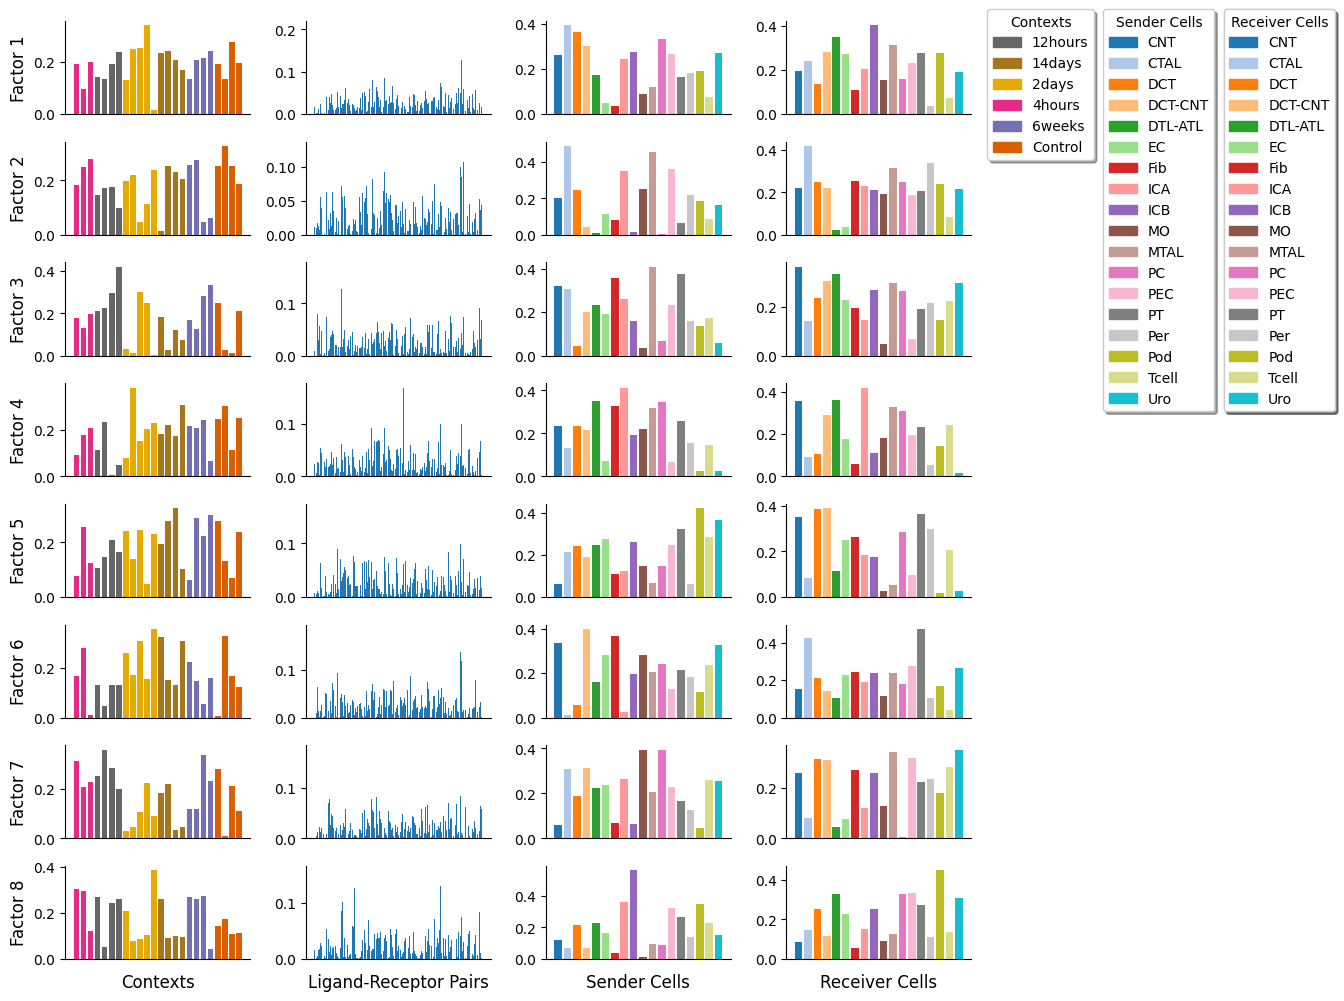

In [90]:
factors, axes = c2c.plotting.tensor_factors_plot(interaction_tensor=tensor,
                                                 metadata = tensor_meta, # This is the metadata for each dimension
                                                 sample_col='Element',
                                                 group_col='Category',
                                                 meta_cmaps = ['Dark2_r', None, 'tab20', 'tab20'],
                                                 reorder_elements={"Contexts": reorder_samples},
                                                 fontsize=10, # Font size of the figures generated
                                                 )

In [91]:
factors = tensor.factors

In [92]:
adata.obs[condition_key].unique()

['4hours', '12hours', '2days', '14days', '6weeks', 'Control']
Categories (6, object): ['2days', '4hours', '6weeks', '12hours', '14days', 'Control']

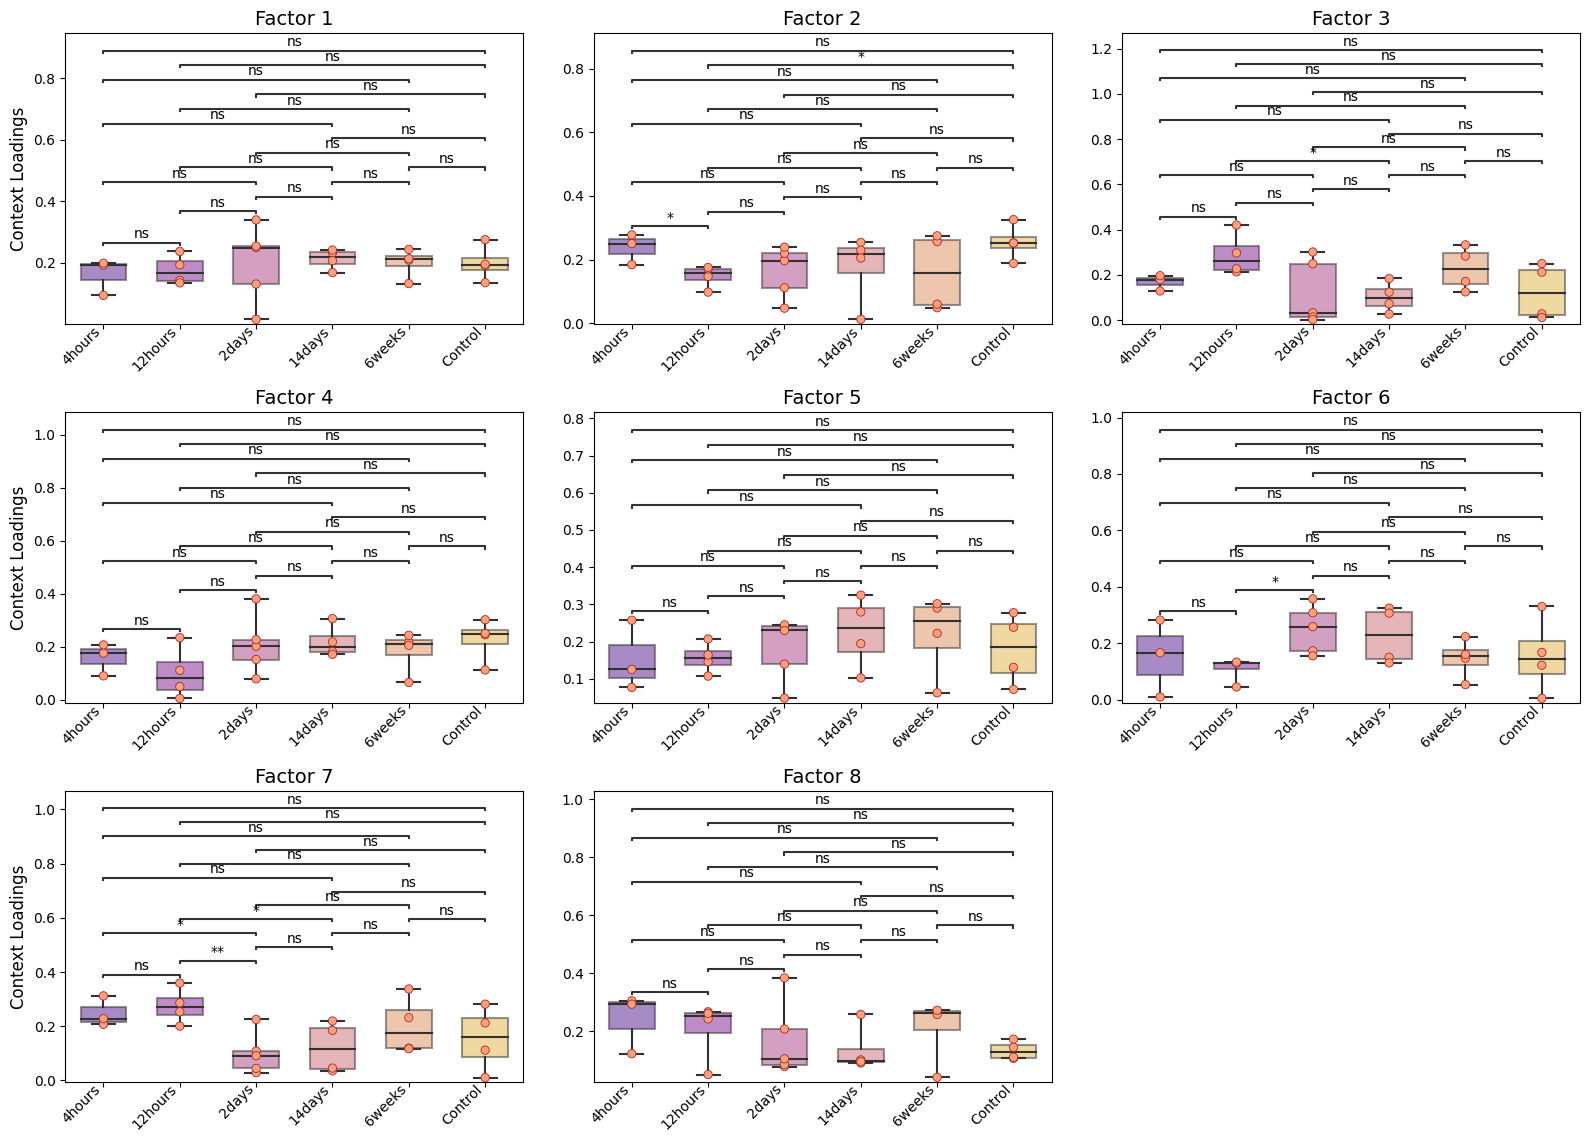

In [93]:
groups_order = ['4hours', '12hours', '2days', '14days', '6weeks', 'Control',]
# fig_filename = output_dir + '/BALF-Severity-Boxplots.pdf'

_ = c2c.plotting.context_boxplot(context_loadings=factors['Contexts'],
                                 metadict=context_dict,
                                 nrows=3,
                                 figsize=(16, 12),
                                 group_order=groups_order,
                                 statistical_test='t-test_ind',
                                 pval_correction=None,
                                 cmap='plasma',
                                 verbose=False,
                                #  filename=fig_filename
                                )


Analysis on one specific Factor

In [181]:
selected_factor = 'Factor 7'

In [182]:
metadata = pd.DataFrame({'Group':dict(context_dict).values()},index=dict(context_dict).keys())

In [183]:
factor_scores = factors['Contexts'].merge(metadata, left_index=True, right_index=True)

In [188]:
from scipy.stats import kruskal

In [190]:
# Extract the values for each group
groups = []
for group_name, group_data in factor_scores.groupby('Group'):
    groups.append(group_data[selected_factor].values)

# Perform the Kruskal-Wallis test
statistic, p_value = kruskal(*groups)

# Print the test results
print("Kruskal-Wallis Test")
print("Statistic:", statistic)
print("P-value:", p_value)

Kruskal-Wallis Test
Statistic: 9.831666666666678
P-value: 0.08014784658739472


In [191]:
loading_product = c2c.analysis.tensor_downstream.get_joint_loadings(factors,
                                                                    dim1='Sender Cells',
                                                                    dim2='Receiver Cells',
                                                                    factor=selected_factor,
                                                                   )



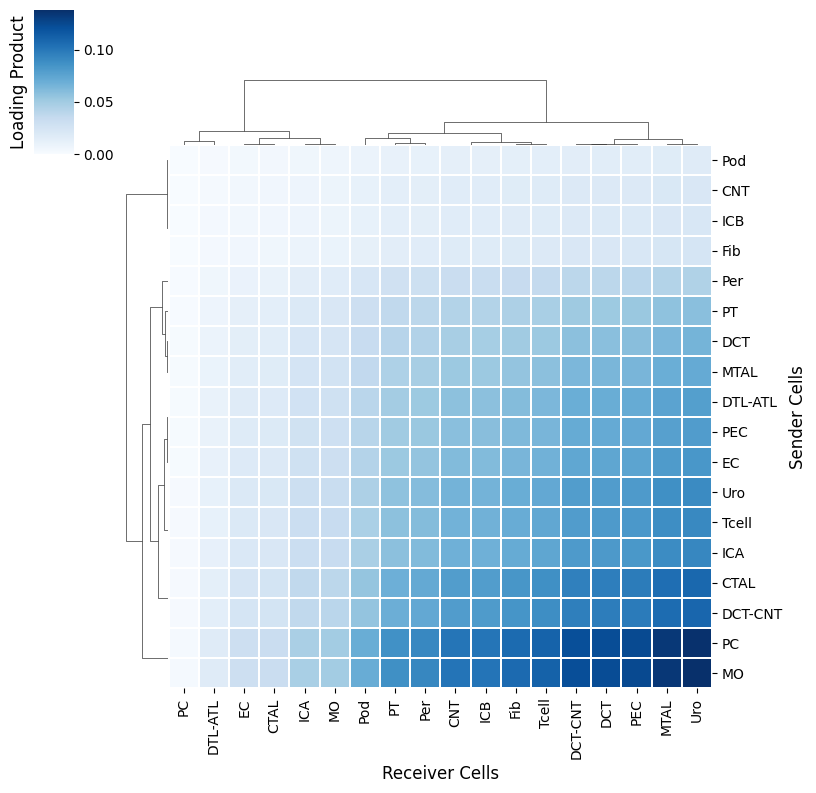

In [192]:
lprod_cm = c2c.plotting.loading_clustermap(loading_product.T, # Remove .T to transpose the axes
                                           use_zscore=False, # Whether standardizing the loadings across factors
                                           figsize=(8, 8),
                                        #    filename=output_folder + 'Clustermap-CC-Pairs.pdf',
                                           cbar_label='Loading Product',
                                          )

In [193]:
lr_cell_product = c2c.analysis.tensor_downstream.get_lr_by_cell_pairs(factors,
                                                                      lr_label='Ligand-Receptor Pairs',
                                                                      sender_label='Sender Cells',
                                                                      receiver_label='Receiver Cells',
                                                                      order_cells_by='receivers',
                                                                      factor=selected_factor,
                                                                      cci_threshold=None, # None for considering all cell-cell pairs.
                                                                      lr_threshold=0.08 # Prioritize important pairs. None for considering all of them
                                                                     )

In [194]:
lrs = lr_cell_product.reset_index()

In [195]:
# to long
lrs = lrs.melt(id_vars=['Ligand-Receptor Pair'])
# sepatate ligands and receptors
lrs[['ligand_complex', 'receptor_complex']] = lrs['Ligand-Receptor Pair'].str.split('^', expand=True)

In [196]:
# separate Sender and Receiver
lrs[['source', 'target']] = lrs['Sender-Receiver Pair'].str.split(' --> ', expand=True)

In [197]:
lrs['size']=3

In [198]:
my_plot = li.pl.dotplot(liana_res = lrs,
                        size='size',
                        colour='value',
                        orderby_ascending=False,
                        size_range=(0.1, 5),
                        figure_size=(6, 8),
                        source_labels=['CNT', 'CTAL', 'DCT', 'DCT-CNT', 'EC', 'Fib', 'ICA'],
                        target_labels=['Fib', 'PEC', 'PT', 'Pod', 'Uro']
                        )

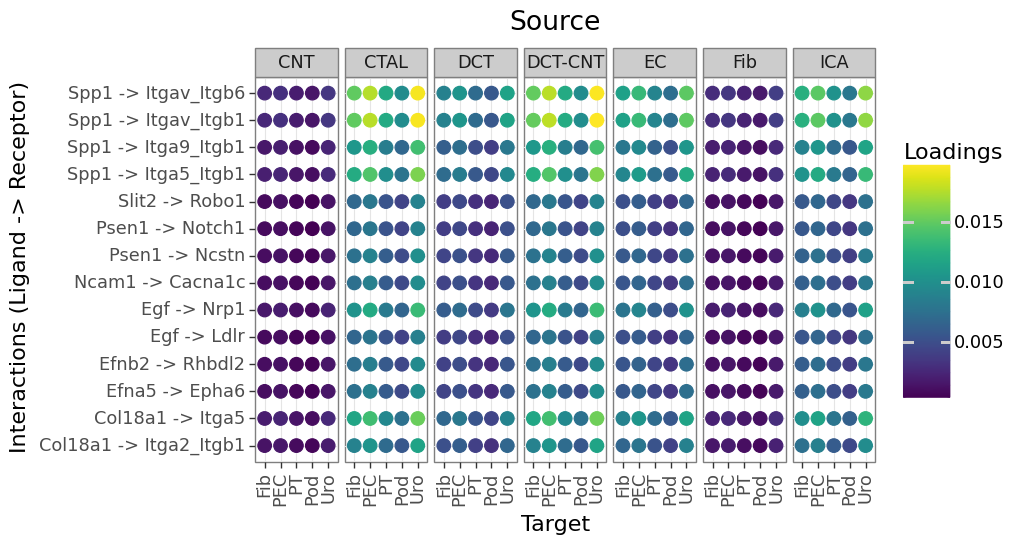

<ggplot: (8779517548397)>

In [199]:
(my_plot + 
 p9.scale_color_cmap() +
 p9.theme_bw(base_size=16) +
 p9.theme(figure_size=(8, 5)) +
p9.theme(axis_text_x=p9.element_text(angle=90)) +
 # remove size from legend
 p9.guides(size=False) +
 p9.labs(color='Loadings')
)

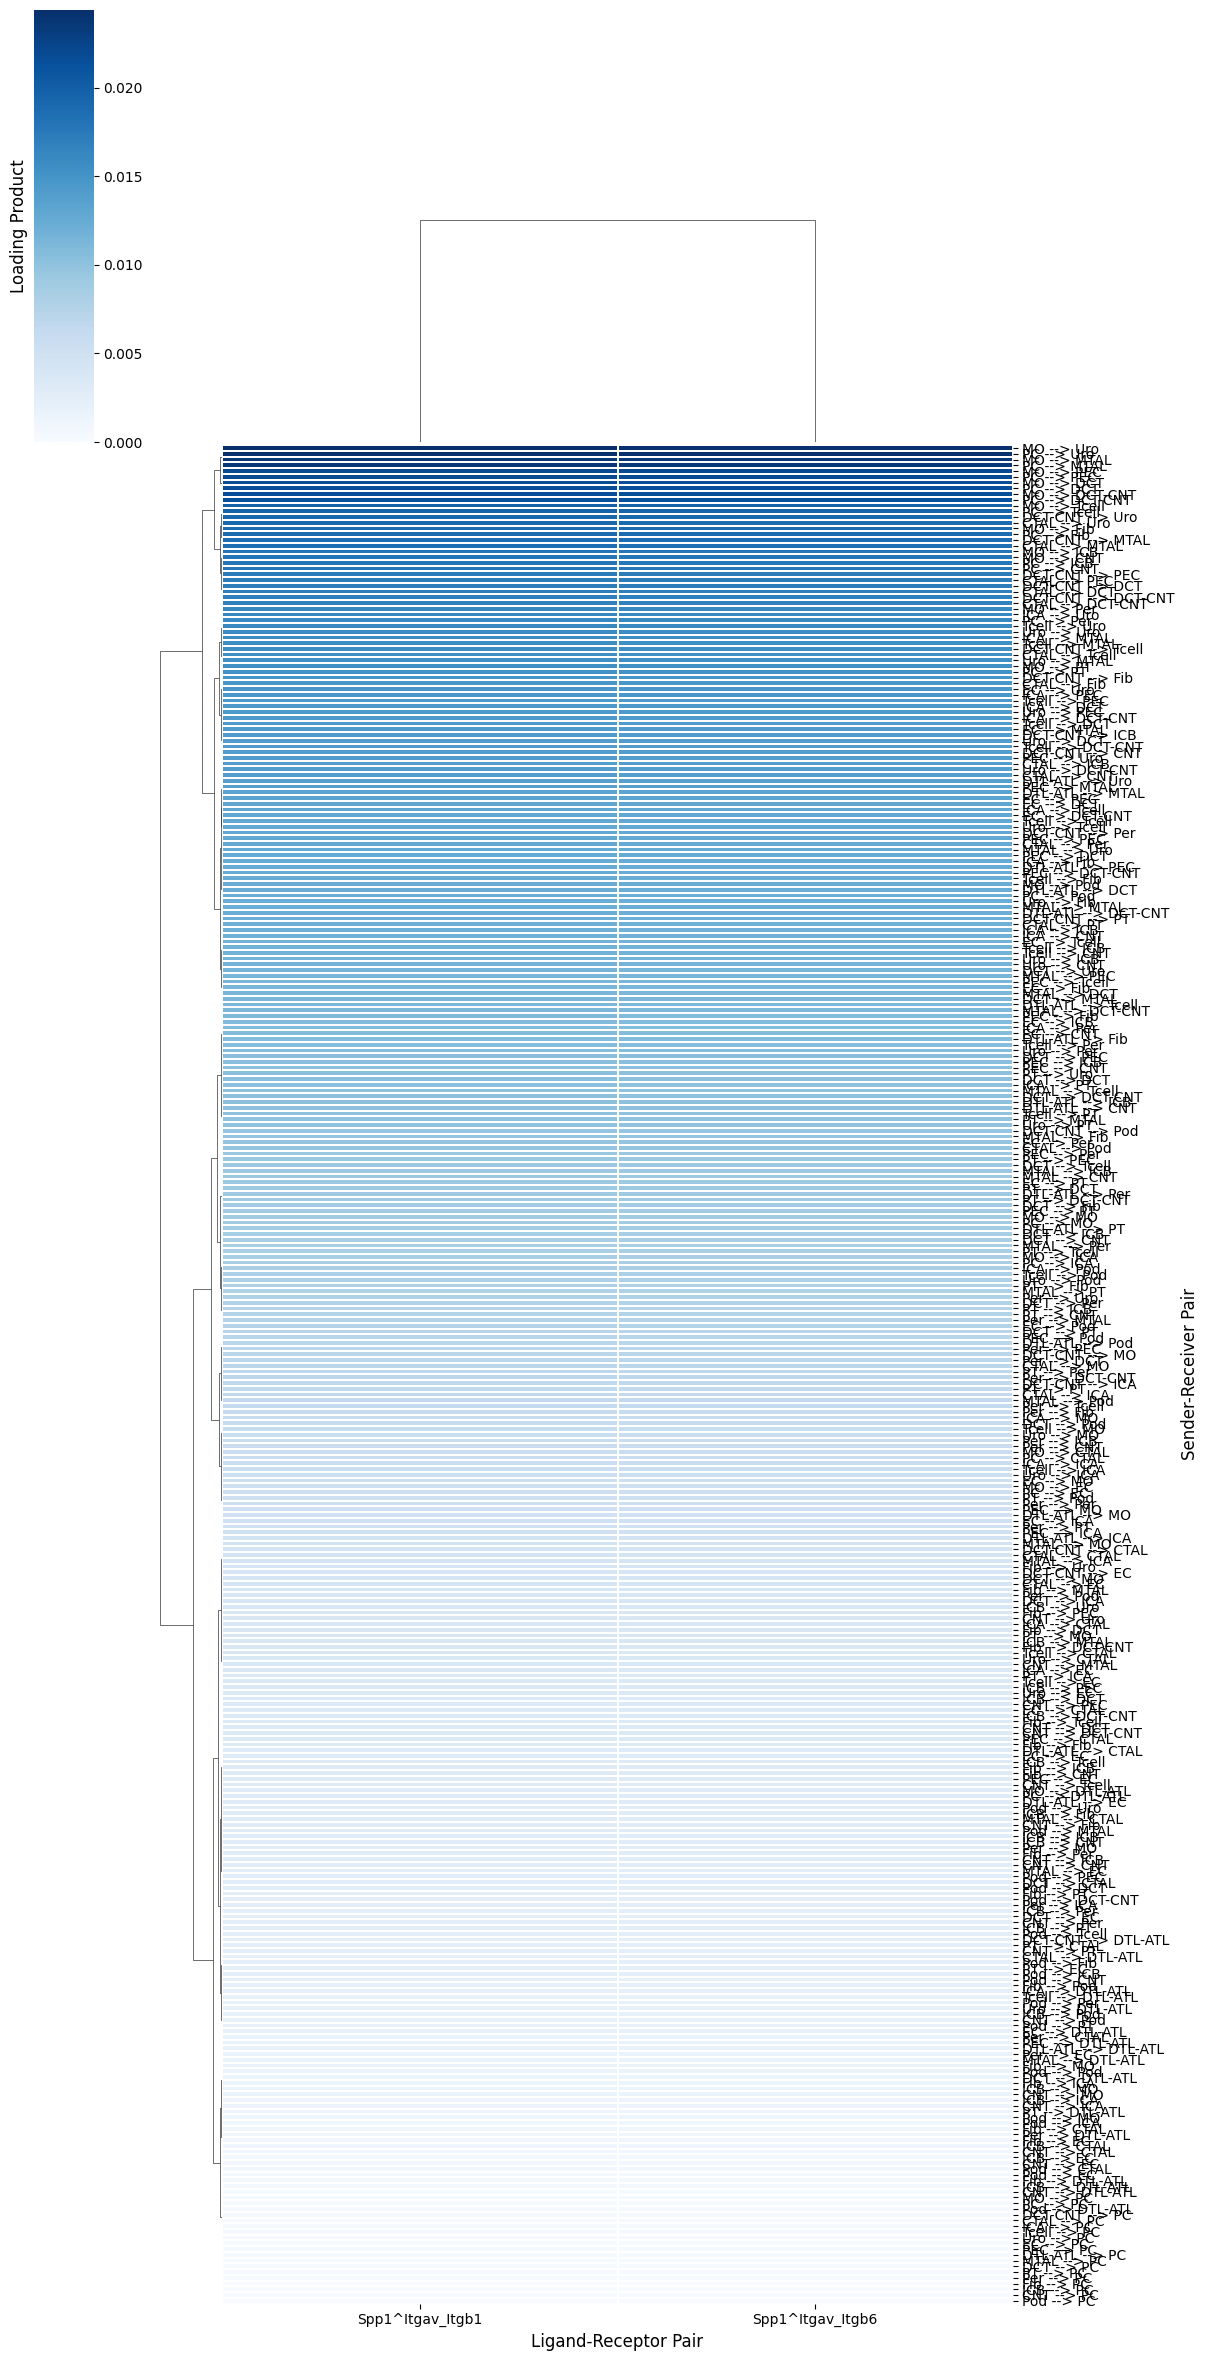

In [100]:
lsr_prod_cm = c2c.plotting.loading_clustermap(lr_cell_product,
                                              use_zscore=False, # Whether standardizing the loadings across factors
                                              figsize=(12, 24),
                                            #   filename=output_folder + 'Clustermap-LR-CC-Pairs.pdf',
                                              cbar_label='Loading Product',
                                              yticklabels=1
                                             )



In [98]:
tensor.factors['Ligand-Receptor Pairs'].sort_values("Factor 7", ascending=False).head(20)

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8
Spp1^Itgav_Itgb1,0.007682,0.065962,0.115393,0.017466,0.015987,0.068394,0.176249,0.039972
Spp1^Itgav_Itgb6,0.023205,0.053498,0.145250,0.021969,0.030854,0.036091,0.175443,0.007928
Spp1^Itga5_Itgb1,0.003740,0.084608,0.142307,0.025386,0.071871,0.090359,0.144539,0.036150
Col18a1^Itga5,0.021904,0.088608,0.104282,0.012056,0.110655,0.038792,0.138976,0.043295
Spp1^Itga9_Itgb1,0.051634,0.076652,0.169974,0.050469,0.043265,0.000111,0.126359,0.026126
Egf^Nrp1,0.033718,0.094384,0.045350,0.023964,0.058203,0.007839,0.122884,0.087703
Col18a1^Itga2_Itgb1,0.063248,0.020783,0.051942,0.043723,0.025461,0.052957,0.106291,0.090989
Psen1^Ncstn,0.041114,0.044263,0.021947,0.038712,0.047639,0.077878,0.092051,0.058823
Efna5^Epha6,0.026505,0.059183,0.000157,0.040201,0.005828,0.021266,0.090571,0.015277
Ncam1^Cacna1c,0.038158,0.067603,0.071425,0.009897,0.087084,0.003888,0.090217,0.085375


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Generate color by COVID-19 severity for each sample
condition_colors = c2c.plotting.aesthetics.get_colors_from_labels(groups_order, cmap='plasma')

# Map these colors to each sample name
color_dict = {k : condition_colors[v] for k, v in context_dict.items()}

# Generate a dataframe used as input for the clustermap
col_colors = pd.Series(color_dict)
col_colors = col_colors.to_frame()
col_colors.columns = ['AKI']



In [ ]:
sample_cm = c2c.plotting.loading_clustermap(factors['Contexts'],
                                            use_zscore=False, # Whether standardizing the loadings across factors
                                            col_colors=col_colors, # Change this to color by other properties
                                            figsize=(16, 6),
                                            dendrogram_ratio=0.3,
                                            cbar_fontsize=12,
                                            tick_fontsize=14,
                                            filename=output_dir + 'Clustermap-Contexts.pdf'
                                           )

#Insert legend
plt.sca(sample_cm.ax_heatmap)
legend = c2c.plotting.aesthetics.generate_legend(color_dict=condition_colors,
                                                 bbox_to_anchor=(1.1, 0.5), # Position of the legend (X, Y)
                                                 title='AKI'
                                                )

